# Diffusion Model Project

In [45]:
# Importing necessary libraries
from functions import *
import torch
import diffusers
from PIL import Image
from tqdm import tqdm

In [46]:
# setup
model_id = "google/ddpm-celebahq-256"  
model = diffusers.UNet2DModel.from_pretrained(model_id)
scheduler = diffusers.DDIMScheduler.from_pretrained(model_id)

An error occurred while trying to fetch google/ddpm-celebahq-256: google/ddpm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


# Forward and Backward Process

In [47]:
# Loading and transforming an image
original_image = Image.open("../images/ddpm_9.png")
original_image = image_as_tensor(original_image)

# input prepraration
image_size = model.config.sample_size # get image size
initial_noise_tensor = torch.randn((1, 3, image_size, image_size)) # sample random noise

num_sampling_steps = 20
scheduler.set_timesteps(num_sampling_steps)

forward_timestep_index = 10

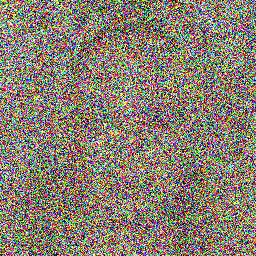

In [49]:
# forward process
noised_image = scheduler.add_noise(original_image, initial_noise_tensor, scheduler.timesteps[forward_timestep_index])
tensor_as_image(noised_image)

""

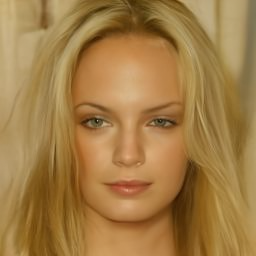

100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


In [50]:
# backward process
current = noised_image
for t in tqdm(scheduler.timesteps[forward_timestep_index:]):
    with torch.no_grad():
        predicted_noise = model(current, t).sample
        current = scheduler.step(predicted_noise, t, current).prev_sample
        show_images(current)

,,

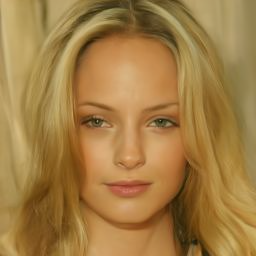
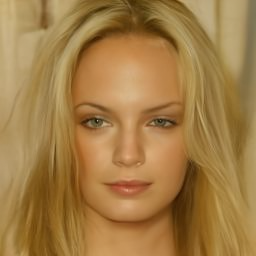
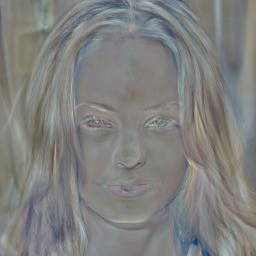

In [51]:
# compare images
show_images(original_image, current, original_image - current)

In [53]:
# setup output image
output = Image.new("RGB", (image_size * num_sampling_steps, image_size * num_sampling_steps), (255, 255, 255))
output.paste(tensor_as_image(original_image), (0, 0))

# output generation
with tqdm(total=sum(range(1, num_sampling_steps+1))) as tqdm_bar:
    for i in reversed(range(num_sampling_steps)):
        sampled_noise = generate_noise(image_size)
        current = scheduler.add_noise(original_image, sampled_noise, scheduler.timesteps[i])
        output.paste(tensor_as_image(current), (0, image_size * (num_sampling_steps - i)))
        for j, t in enumerate(scheduler.timesteps[i:]):
            with torch.no_grad():
                predicted_noise = model(current, t).sample
                current = scheduler.step(predicted_noise, t, current).prev_sample
                output.paste(tensor_as_image(current), (image_size * (j + 1), image_size * (num_sampling_steps - i)))
            tqdm_bar.update(1)

# save output image
output.save("../output/process.png")

100%|██████████| 210/210 [05:16<00:00,  1.51s/it]
